In [2]:
rm(list = ls())
library(data.table)
library(magrittr)
library(Rcpp)

sourceCpp("shapeDTW_translate/dpcore.cpp")
source("dpfast.R")
source("dist2.R")
source("shapeDTW_translate/shapeDTW.R")
source("shapeDTW_translate/DTWfast.R")
source("shapeDTW_translate/hist_cost_2.R")
source("shapeDTW_translate/zNormalizeTS.R")
source("shapeDTW_translate/hist_cost_2.R")
source("shapeDTW_translate/samplingSequencesIdx.R")
source("shapeDTW_translate/calcDescriptor.R")
source("shapeDTW_translate/descriptorPAA.R")
source("shapeDTW_translate/PAA.R")
source("shapeDTW_translate/descriptorHOG1D.R")
source("shapeDTW_translate/validatePAAparam.R")
source("shapeDTW_translate/validatePAAdescriptorparam.R")
source("shapeDTW_translate/validateHOG1Dparam.R")
source("shapeDTW_translate/validateDWTdescriptorparam.R")
source("shapeDTW_translate/whichInterval.R")
source("shapeDTW_translate/wpath2mat.R")
source("shapeDTW_translate/plotElasticMatching.R")

### 1. Load in Beef Data

Food spectrographs are used in chemometrics to classify food types, a task that has obvious applications in food safety and quality assurance. The beef data set consists of four classes of beef spectrograms, from pure beef and beef adulterated with varying degrees of offal. Further information can be found in the original paper by Jowder et al. [1]. The data were first used in the time series classification literature by Bagnall et al. [2].

- Train size: 30, Test size: 30

- Missing value: No

- Number of classses: 5

- Time series length: 470

[1] Al-Jowder, Osama, E. K. Kemsley, and Reginald H. Wilson. "Detection of adulteration in cooked meat products by mid-infrared spectroscopy." Journal of agricultural and food chemistry 50.6 (2002): 1325-1329.

[2] Bagnall, Anthony, et al. "Transformation based ensembles for time series classification." Proceedings of the 2012 SIAM international conference on data mining. Society for Industrial and Applied Mathematics, 2012.

[3] http://www.timeseriesclassification.com/description.php?Dataset=Beef

In [3]:
ts <- fread("UCRArchive_2018/Beef/Beef_TRAIN.tsv")[ , 1:201]

nInstances <- nrow(ts)
seqlen <- 20  # Subsequence length
ts_data <- ts[, -1] # Time series data
ts_labels <- ts[, 1] # Label
nObs <- ncol(ts_data)

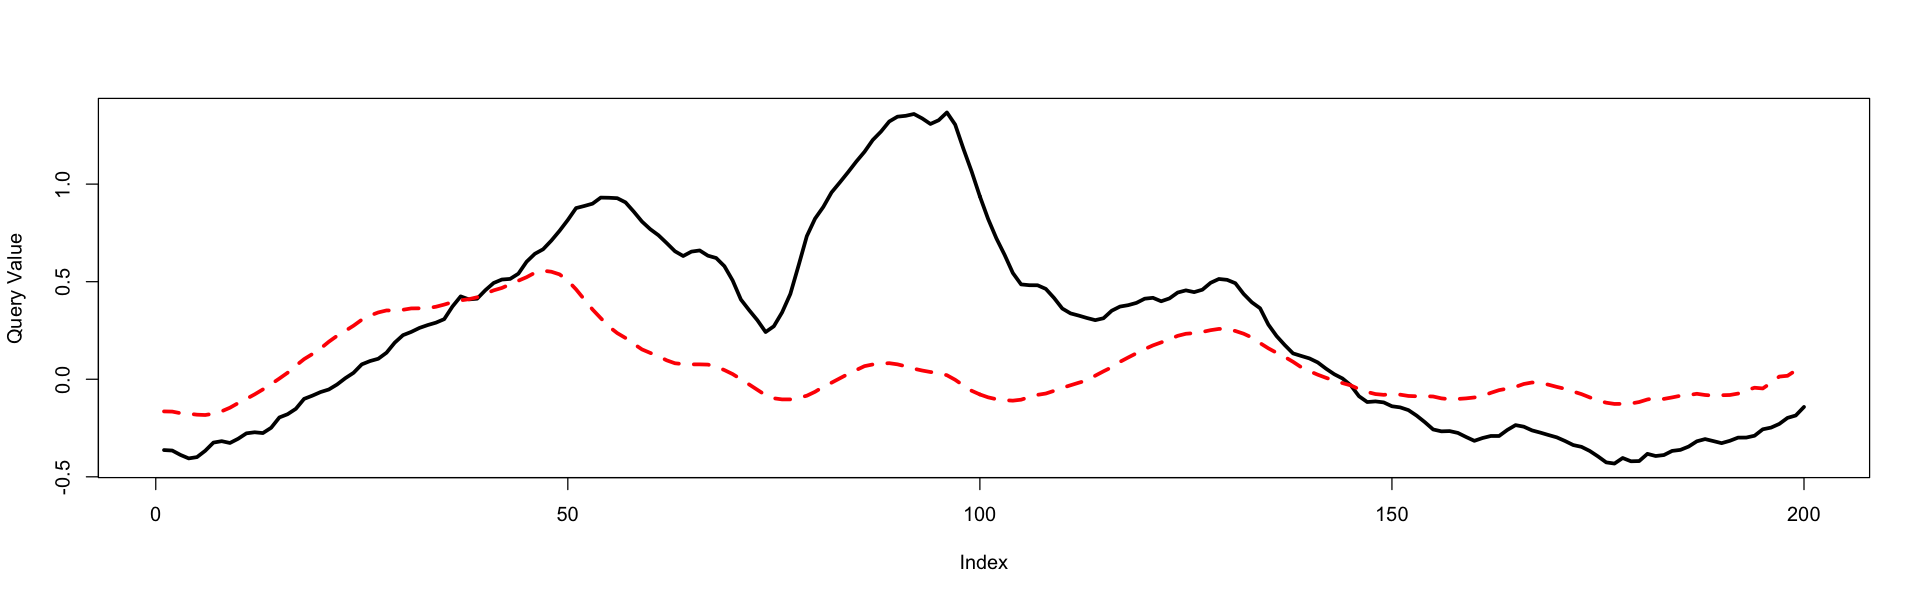

In [4]:
options(repr.plot.width = 16, repr.plot.height = 5)
plot(1:nObs, as.numeric(ts_data[1, ]), type = "l", lwd = 3, xlab = "Index", ylab = "Query Value")
lines(1:nObs, as.numeric(ts_data[20, ]), type = "l", lwd = 3, lty= "dashed", col = "red")

### 2. Experiment ``shapeDTW`` on Beef Data

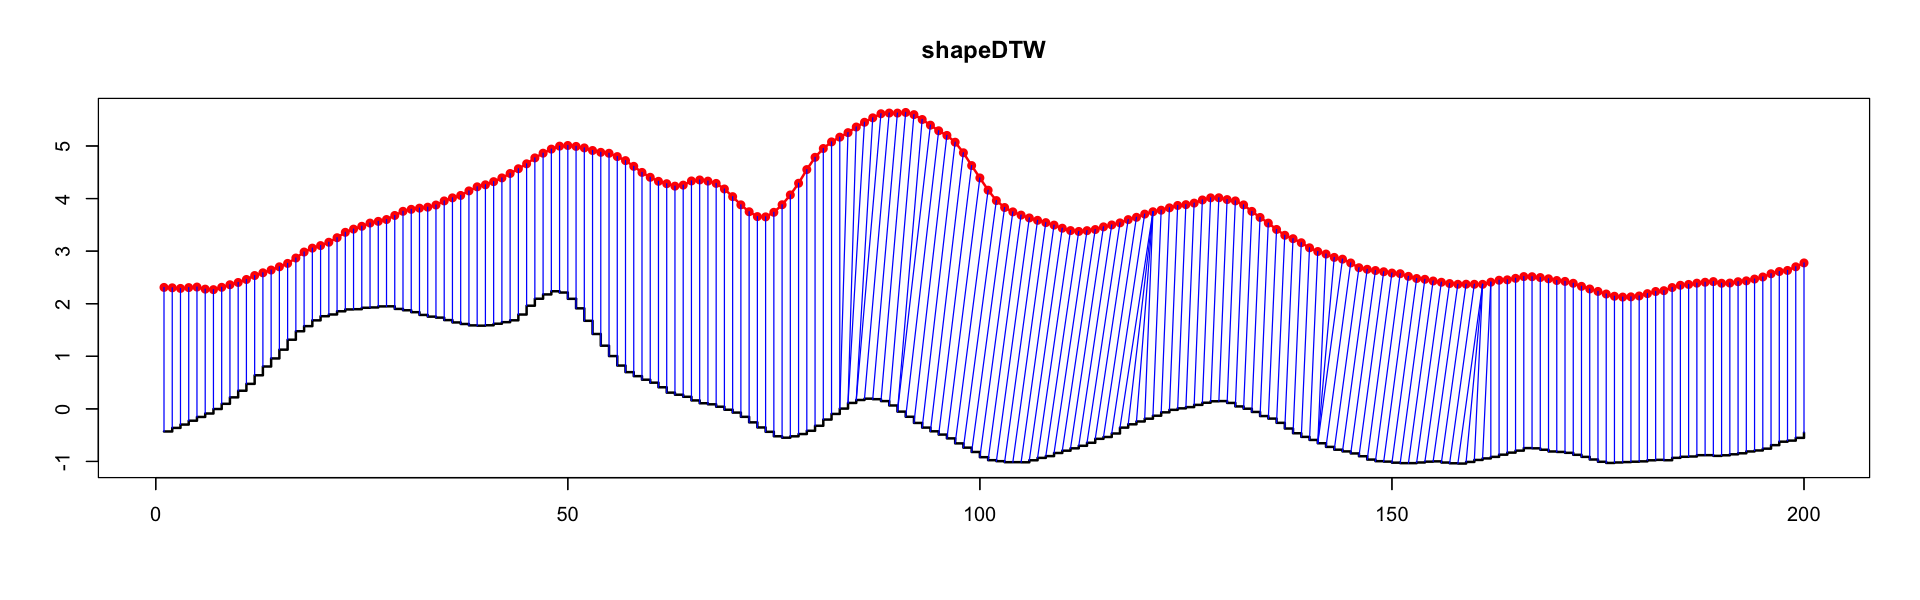

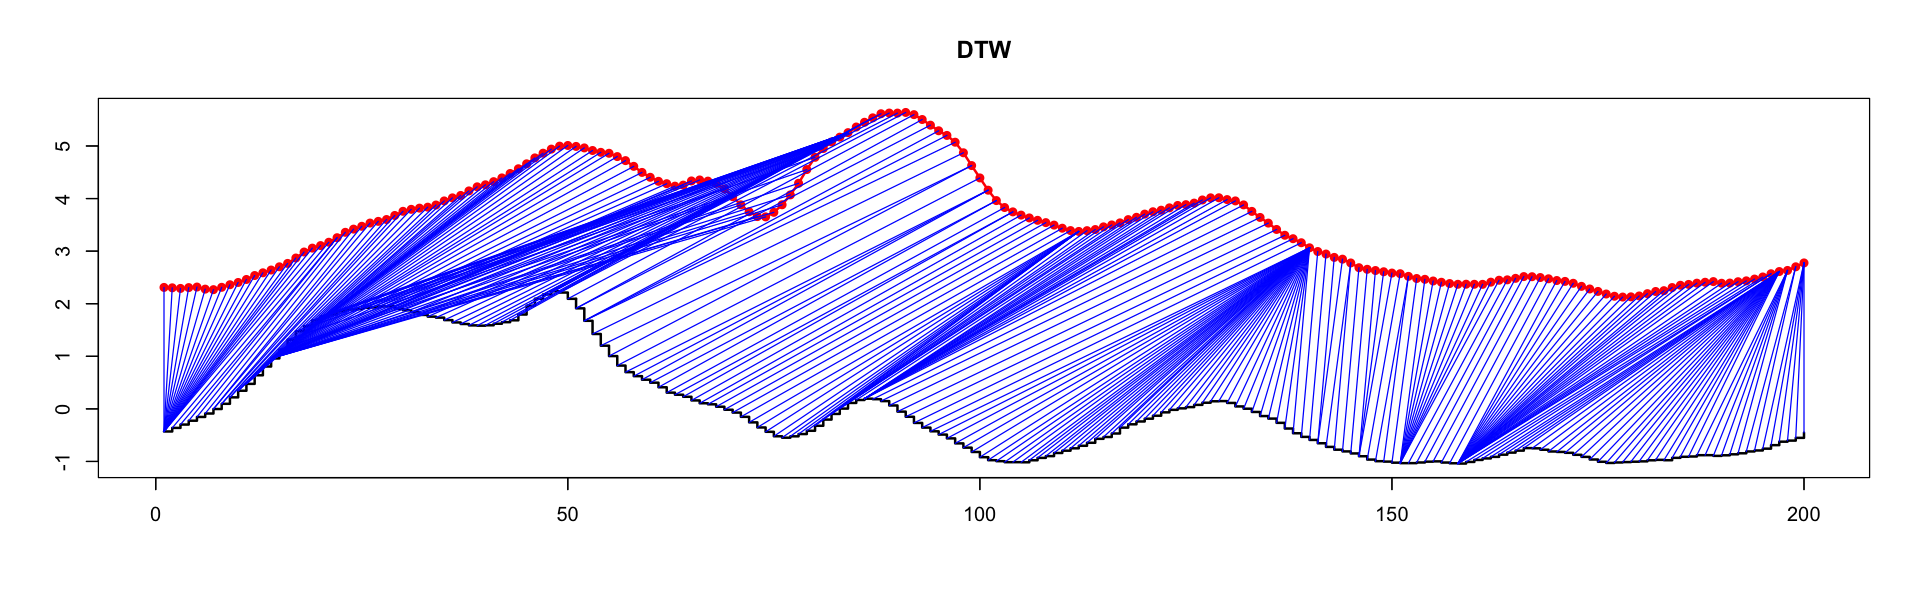

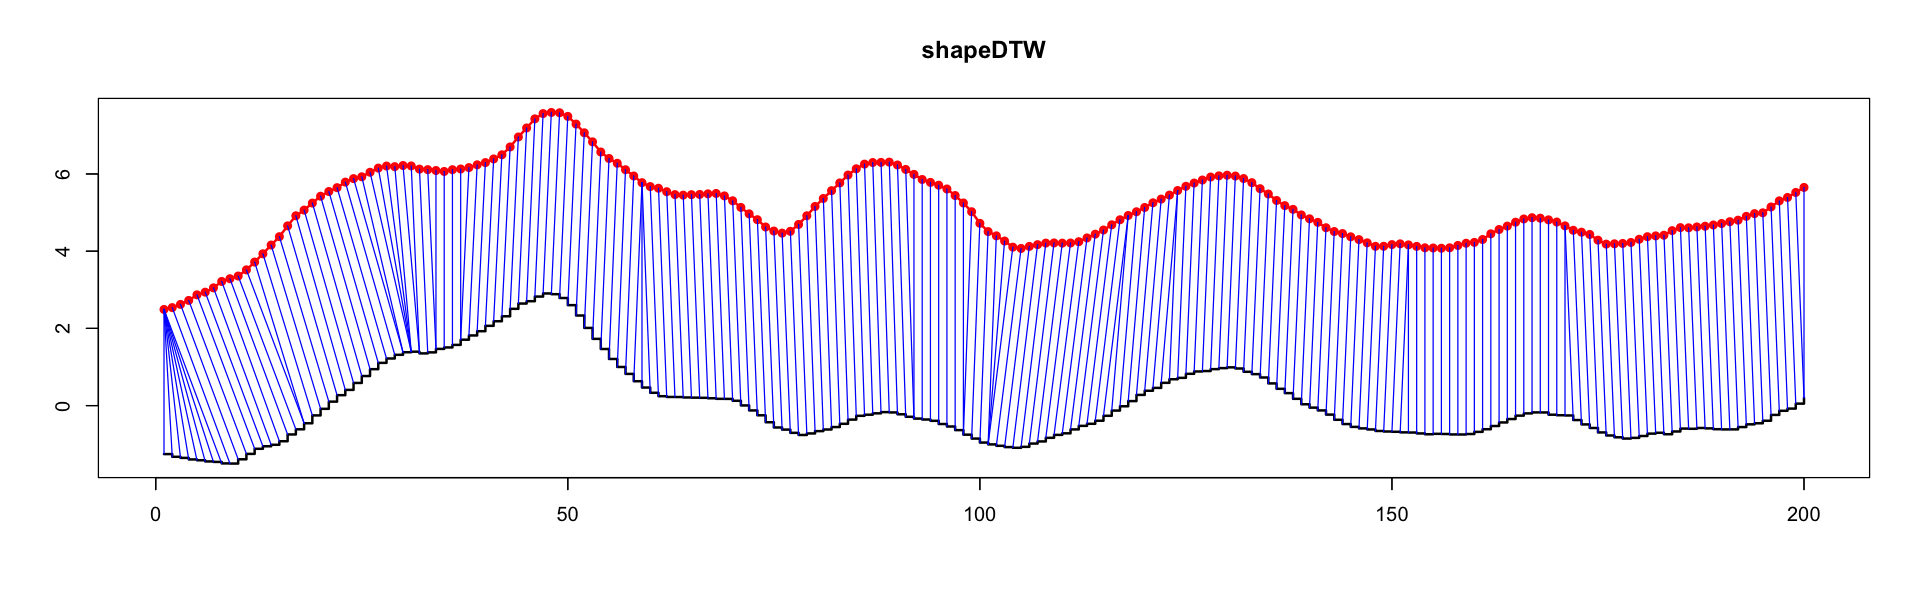

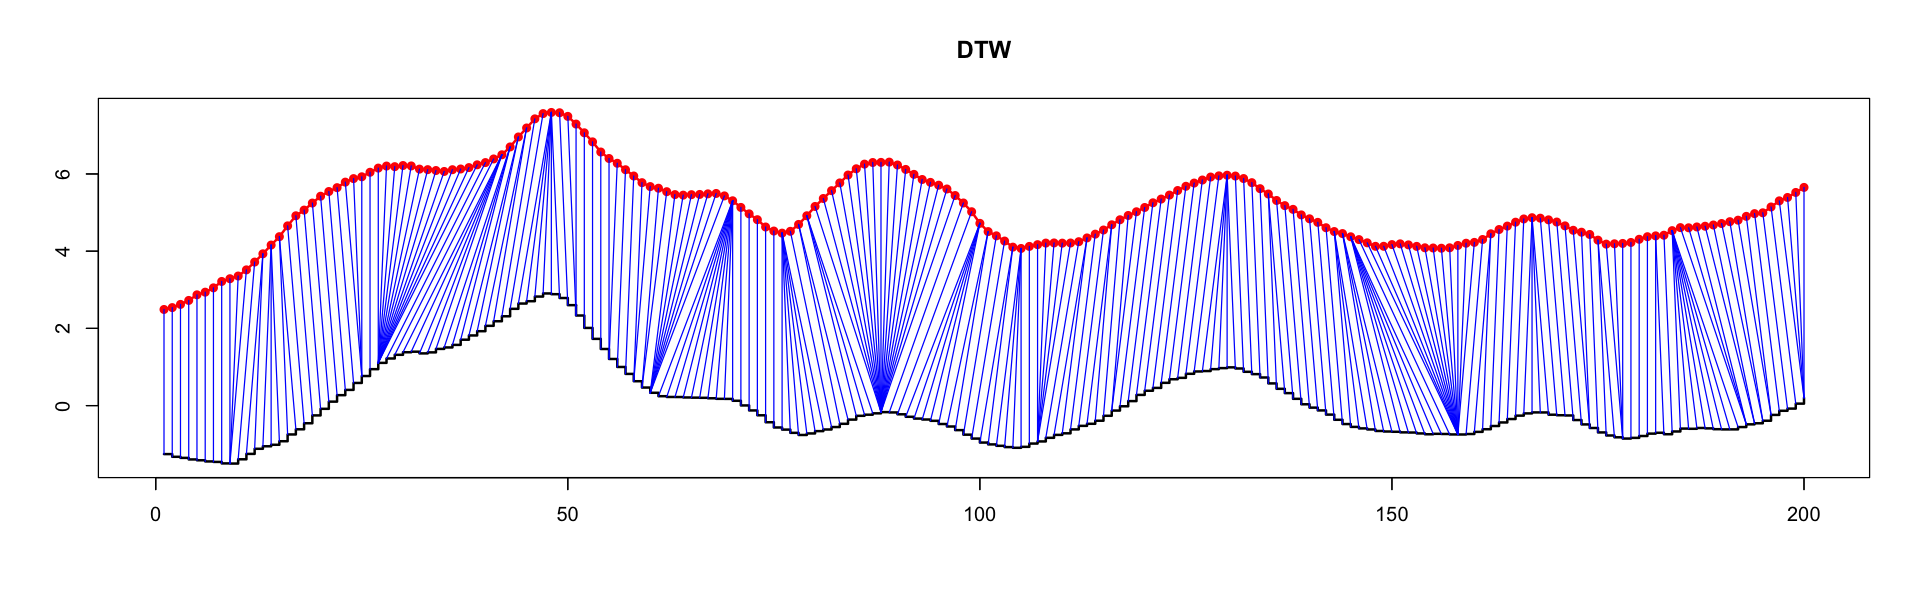

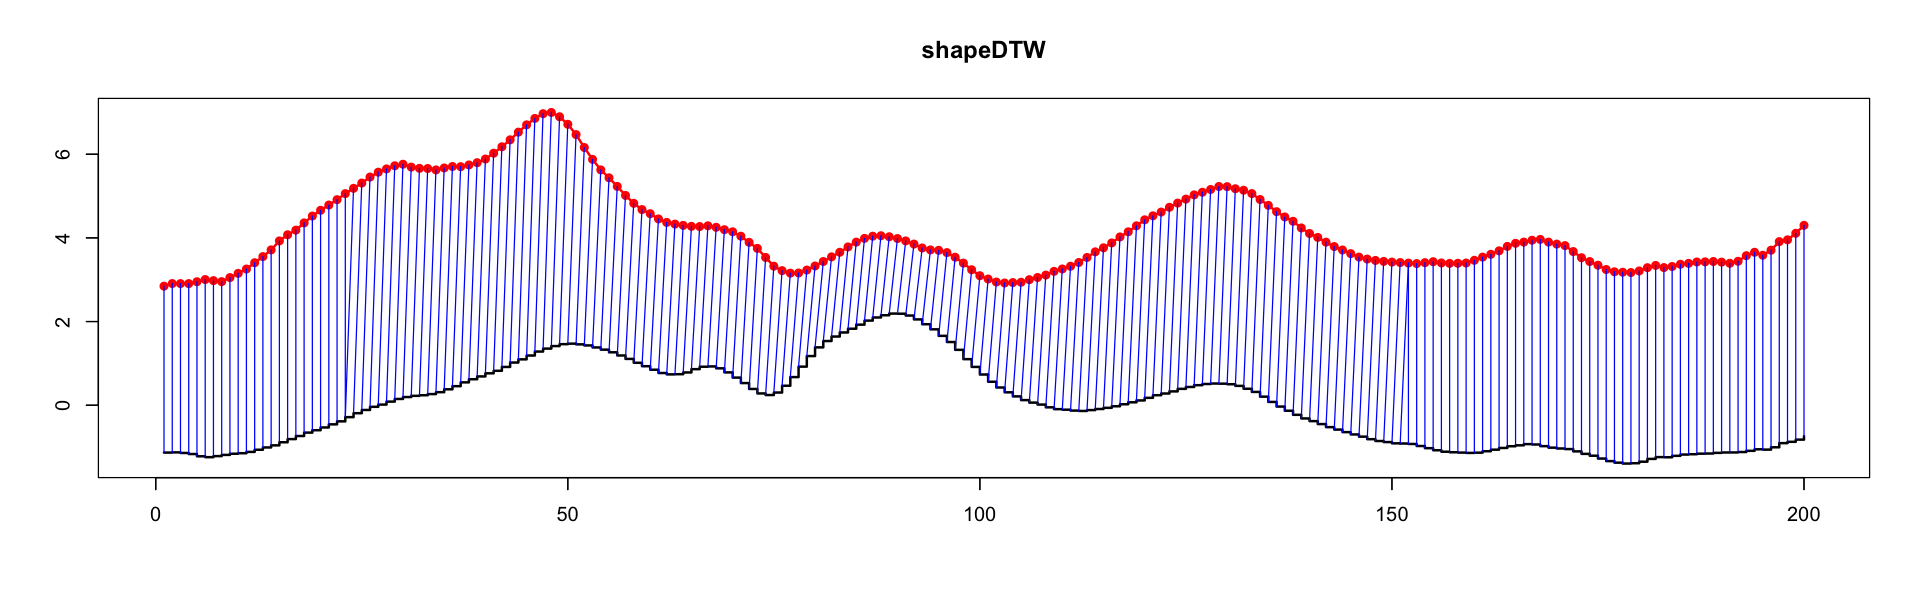

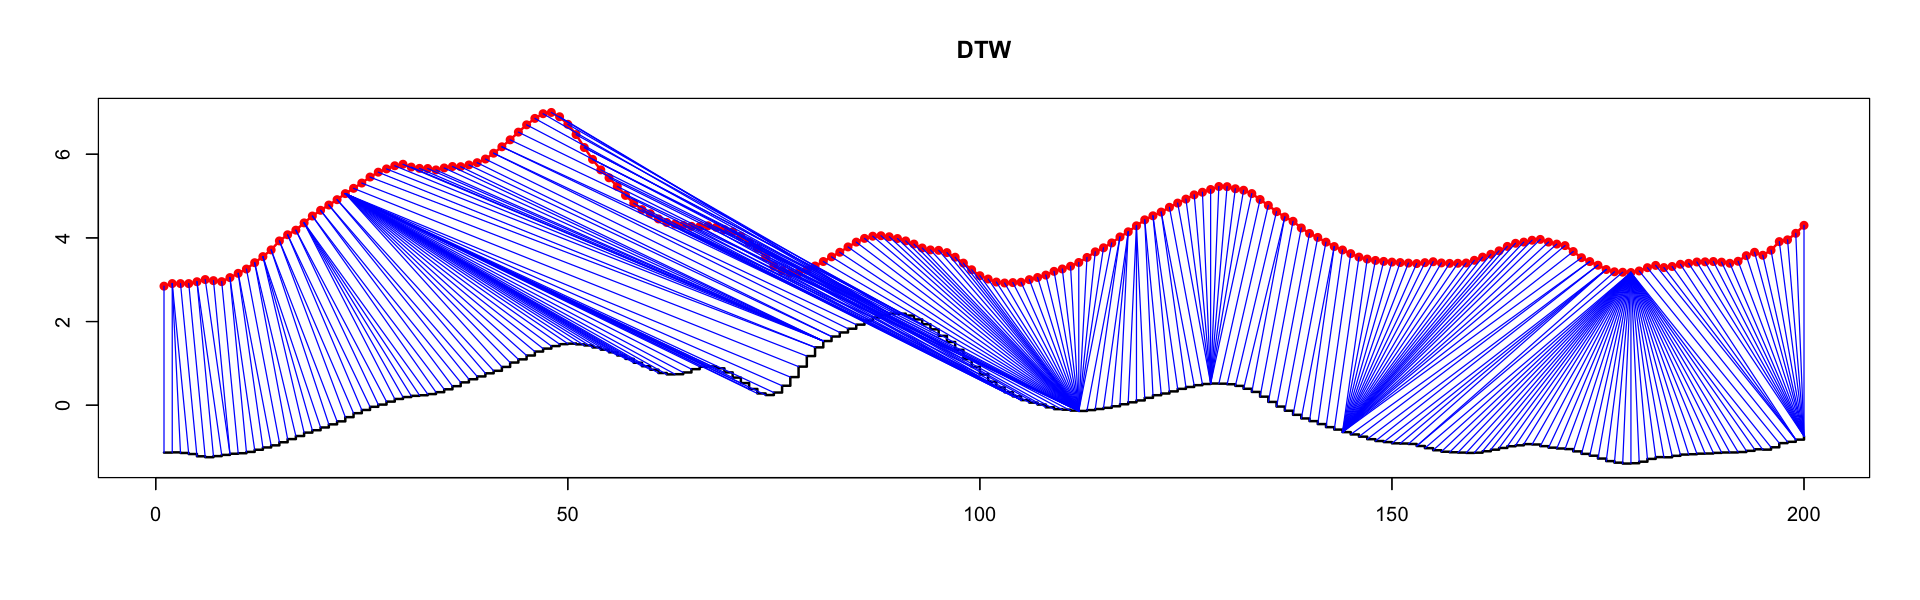

In [5]:
nExp <- 3 # Number of experiments

# Run alignment
for (i in 1:nExp) {

  # Randomly sample two sequences and normalize the sequences
  p <- zNormalizeTS(unlist(ts_data[sample(nInstances, 1), ]))
  q <- zNormalizeTS(unlist(ts_data[sample(nInstances, 1), ]))
  
  # run shapeDTW
  align_shapeDTW <- shapeDTW(p, q, seqlen)
  plotElasticMatching(p, q, align_shapeDTW$match)
  title("shapeDTW")
  
  # Run traditional DTW
  align_dtw <- DTWfast(p, q)
  plotElasticMatching(p, q, align_dtw$match)
  title("DTW")
  
}


### 3. Experiment ``shapeDTW`` on Simulation Data

In [6]:
dt <- fread("data/testdata.csv")

# Get the sequences
seq_ref <- as.matrix(dt[label == "ref"]$value)
seq_q1 <- as.matrix(dt[label == "q1"]$value)
seq_q2 <- as.matrix(dt[label == "q2"]$value)
cat(paste0("Dimension of Reference Sequence: ", paste(dim(seq_ref), collapse = " x "),
           "\nDimension of 1st Query Sequence: ", paste(dim(seq_q1), collapse = " x "),
           "\nDimension of 2nd Query Sequence: ", paste(dim(seq_q2), collapse = " x ")))

Dimension of Reference Sequence: 104 x 1
Dimension of 1st Query Sequence: 104 x 1
Dimension of 2nd Query Sequence: 104 x 1

pairs,distRaw,distDescriptor
<chr>,<dbl>,<dbl>
ref vs. q1,21.28108,189.8650
ref vs. q2,17.68448,181.9432


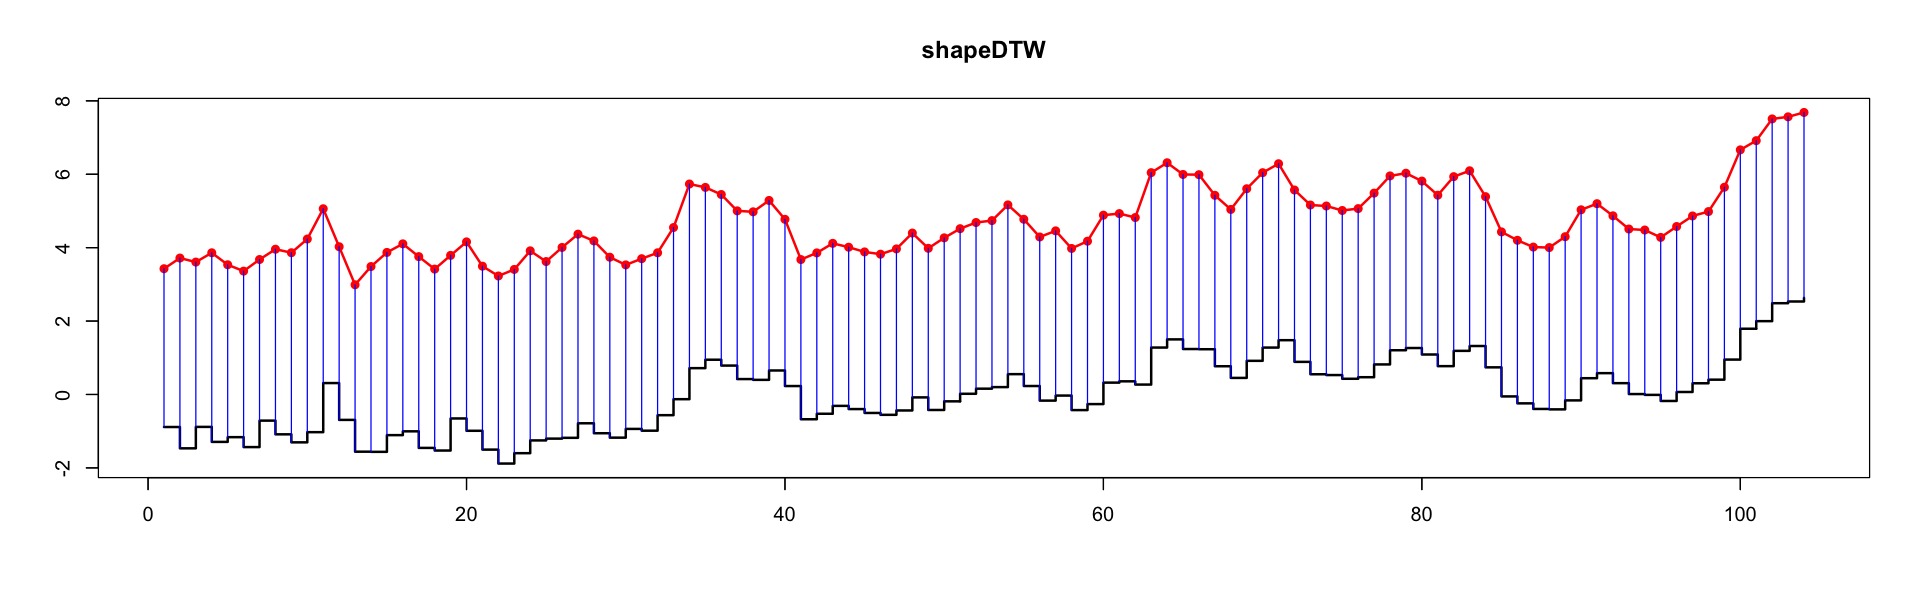

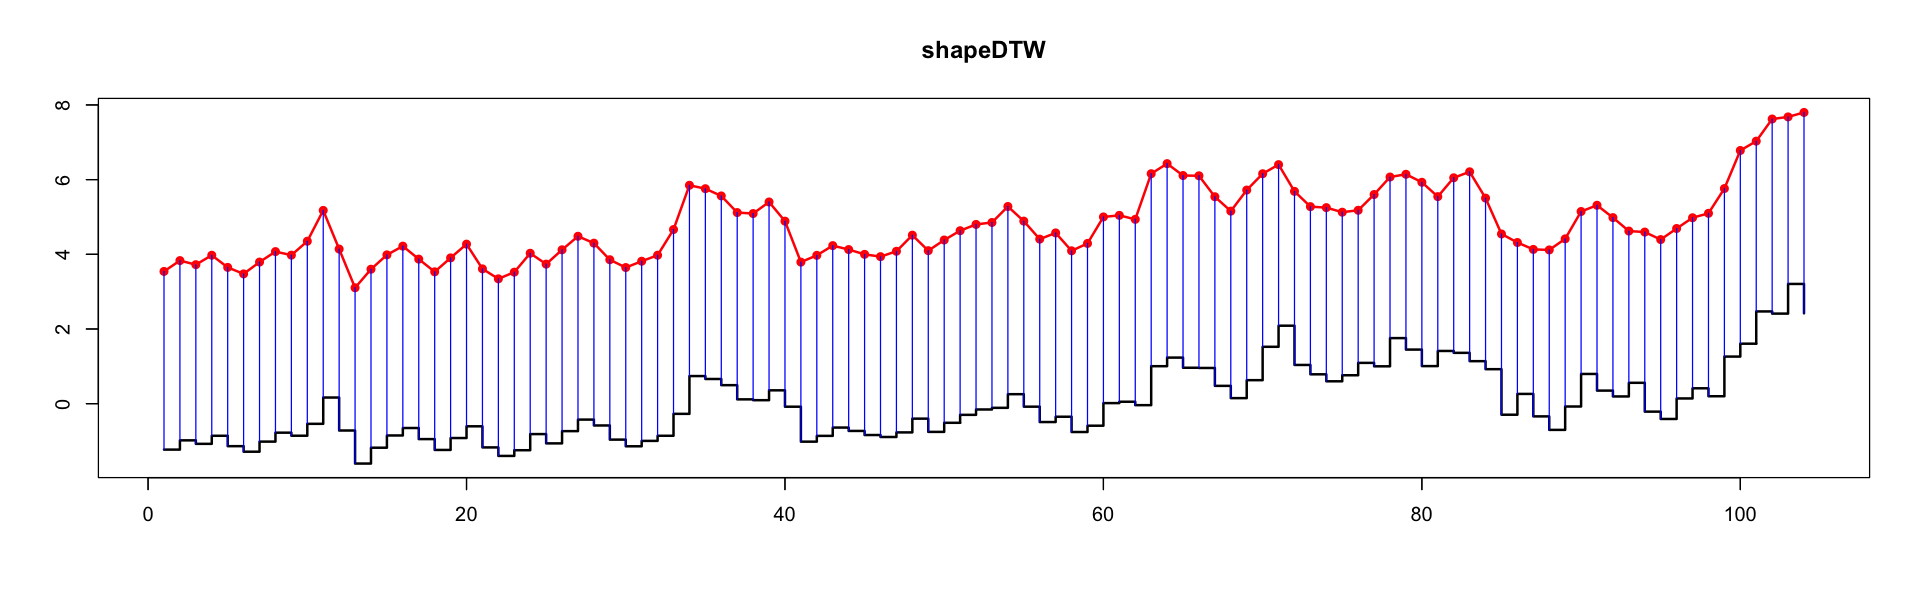

In [7]:
# Define subsequence length
seqlen <- 8

# Normalize sequences
p_ref <- zNormalizeTS(seq_ref)
q_1 <- zNormalizeTS(seq_q1)
q_2 <- zNormalizeTS(seq_q2)

# Run shapeDTW: reference vs. query 1 || reference vs. query 2
align_shapeDTW_1 <- shapeDTW(as.vector(p_ref), as.vector(q_1), seqlen)
align_shapeDTW_2 <- shapeDTW(as.vector(p_ref), as.vector(q_2), seqlen)

# Output minimum distance
cost_comparison <- data.frame(matrix(NA, nrow = 2, ncol = 3))
colnames(cost_comparison) <- c("pairs", "distRaw", "distDescriptor")
cost_comparison[, 1] <- c("ref vs. q1", "ref vs. q2")
cost_comparison[, 2] <- c(align_shapeDTW_1$distRaw, align_shapeDTW_2$distRaw)
cost_comparison[, 3] <- c(align_shapeDTW_1$distDescriptor, align_shapeDTW_2$distDescriptor)
cost_comparison

# Plot matching result
plotElasticMatching(p_ref, q_1, align_shapeDTW_1$match)
title("shapeDTW")

plotElasticMatching(p_ref, q_2, align_shapeDTW_2$match)
title("shapeDTW")
